# FOMO - Faster Objects, More Objects

### Import modules

In [1]:
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

### Constants

In [2]:
DATASET_DIR = Path('vehicle_detection_dataset')
IMAGE_RESOLUTION = 1280
GRID_SCALE = 8
GRID_RESOLUTION = int(IMAGE_RESOLUTION / GRID_SCALE)

### Dataset and Dataloader

In [3]:
class VehicleDataset(Dataset):
    def __init__(self, dataset_dir: Path, subset: list[str], transform=None):
        self._images = [dataset_dir / 'images' / (element + ".jpg") for element in subset]
        self._bounding_boxes = [dataset_dir / 'bounding_boxes' / (element + ".txt") for element in subset]
    
    def __getitem__(self, idx: int):
        image_file = self._images[idx]
        image = read_image(str(image_file))

        bounding_box_file = self._bounding_boxes[idx]
        mask = torch.zeros((GRID_RESOLUTION, GRID_RESOLUTION), dtype=int)
        with open(bounding_box_file) as bb_file:
            bounding_boxes = bb_file.readlines()
            for bounding_box in bounding_boxes:
                [c, x, y, w, h] = [float(coords) for coords in bounding_box.split()]
                xp = int((x + (w / 2)) * IMAGE_RESOLUTION)
                yp = int((y + (h / 2)) * IMAGE_RESOLUTION)
                xp_idx = int(xp / GRID_SCALE)
                yp_idx = int(yp / GRID_SCALE)
                mask[yp_idx, xp_idx] = c + 1

        return image, mask

    def __len__(self):
        return len(self._images)

TESTS

There are 6 objects in the picture


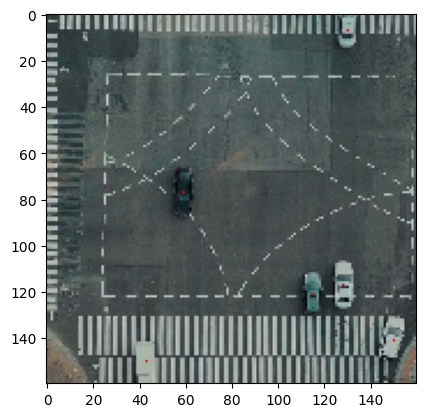

In [4]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

subset = [str(i) for i in range(70,80)]
dataset = VehicleDataset(DATASET_DIR, subset)
image, mask = dataset[0]

image = image.permute(1, 2, 0).numpy()
image_res = cv2.resize(image, dsize=(GRID_RESOLUTION, GRID_RESOLUTION))
image_res[mask == 1] = [255, 0, 0]
plt.imshow(image_res)

cnt = np.count_nonzero(mask == 1)
print("There are", str(cnt), "objects in the picture")